<a href="https://colab.research.google.com/github/Aldwin-b/PriceList/blob/main/PriceList_MDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Digit Number Recognition

Original Project https://github.com/ozanpekmezci/capstone/blob/master/multi_digit_recognition.ipynb

In [ ]:
# Module Imports

import numpy as np
from __future__ import print_function
import random
import glob
import cv2
import os


import numpy as np
from scipy import misc
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [ ]:
# Setting the random seed so that the results are reproducible. 
random.seed(42)

# Setting variables for MNIST image dimensions
mnist_image_height = 28
mnist_image_width = 28

In [ ]:
# Import MNIST data from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Shape of training dataset: (60000, 28, 28)
Shape of test dataset: (10000, 28, 28)
Label for image: 5


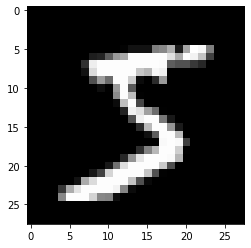

In [ ]:
#Checking the downloaded data
print("Shape of training dataset: {}".format(np.shape(X_train)))
print("Shape of test dataset: {}".format(np.shape(X_test)))


plt.figure()
plt.imshow(X_train[0], cmap='gray')

print("Label for image: {}".format(y_train[0]))

## Building a new dataset
This method builds a new synthetic dataset that stitches multiple digits together. Labels and data can contain numbers from 0 to 9 including the blank character for shorter house numbers. The length is preset to be always 5.

In [ ]:
def build_synth_data(data, labels, dataset_size):
    
    # Define synthetic image dimensions
    synth_img_height = 64
    synth_img_width = 64
    
    # Define synthetic data
    synth_data = np.ndarray(shape=(dataset_size, synth_img_height,
                                   synth_img_width), dtype=np.float32)
    
    # Define synthetic labels
    synth_labels = [] 
    
    # For a loop till the size of the synthetic dataset
    for i in range(0,dataset_size):
        
        # Pick a random number of digits to be in the dataset
        num_digits = random.randint(1,5)
        
        # Randomly sampling indices to extract digits + labels afterwards
        s_indices = [random.randint(0, len(data)-1) for p in range(0, num_digits)]
        
        # stitch images together
        new_image = np.hstack([X_train[index] for index in s_indices])
        # stitch the labels together
        new_label =  [y_train[index] for index in s_indices]
        
        
        # Loop till number of digits - 5, to concatenate blanks images, and blank labels together
        for j in range(0,5-num_digits):
            new_image = np.hstack([new_image, np.zeros(shape=(mnist_image_height,
                                                                   mnist_image_width))])
            new_label.append(10) #Might need to remove this step
        
        # Resize image
        new_image =cv2.resize(new_image,(64,64))
        
        # Assign the image to synth_data
        synth_data[i,:,:] = new_image
        
        # Assign the label to synth_data
        synth_labels.append(tuple(new_label))
        
    
    # Return the synthetic dataset
    return synth_data,synth_labels

In [ ]:
# Building the training dataset
X_synth_train, y_synth_train = build_synth_data(X_train, y_train, 60000)

In [ ]:
# Building the test dataset
X_synth_test, y_synth_test = build_synth_data(X_test, y_test, 10000)

## Convert Labels
This function converts each digit label to one-hot array.

In [ ]:
# Converting labels to One-hot representations of shape (set_size, digits, classes)
possible_classes = 11

def convert_labels(labels):
    
    # As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    # Each digit array will be of shape (60000,11)
        
    # Declare output ndarrays
    # 5 for digits, 11 for possible classes  
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        
        # Using np_utils from keras to OHE the labels in the image
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

In [ ]:
train_labels = convert_labels(y_synth_train)
test_labels = convert_labels(y_synth_test)

## Prepare Data for Keras
Reshape image data to be processed by Keras.

In [ ]:
def prep_data_keras(img_data):
    
    # Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data), 64, 64, 1)
    
    # Converting everything to floats
    img_data = img_data.astype('float32')
    
    # Normalizing values between 0 and 1
    img_data /= 255
    
    return img_data


In [ ]:
train_images = prep_data_keras(X_synth_train)
test_images = prep_data_keras(X_synth_test)

In [ ]:
# Importing relevant keras modules
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D

## Build Model
Build Deep Learning model to process data.

In [ ]:
# Building the model

batch_size = 128
nb_classes = 11
nb_epoch = 15

# image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

# number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# defining the input
inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Conv2D(nb_filters, kernel_size=kernel_size, padding='same')(inputs)
cov = Activation('relu')(cov)
cov = Conv2D(nb_filters, kernel_size=kernel_size, padding='same')(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.25)(cov)
cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(128, activation='relu')(cov_out)
cov2 = Dropout(0.5)(cov2)



# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Fitting the model
model.fit(train_images,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,
          validation_data=(test_images, test_labels))

Epoch 1/15
469/469 [==============================] - 32s 65ms/step - loss: 3.6486 - dense_7_loss: 0.9279 - dense_8_loss: 0.8801 - dense_9_loss: 0.7715 - dense_10_loss: 0.6507 - dense_11_loss: 0.4184 - dense_7_accuracy: 0.6865 - dense_8_accuracy: 0.7090 - dense_9_accuracy: 0.7478 - dense_10_accuracy: 0.7928 - dense_11_accuracy: 0.8705 - val_loss: 1.0306 - val_dense_7_loss: 0.2449 - val_dense_8_loss: 0.2294 - val_dense_9_loss: 0.2227 - val_dense_10_loss: 0.1732 - val_dense_11_loss: 0.1604 - val_dense_7_accuracy: 0.9395 - val_dense_8_accuracy: 0.9413 - val_dense_9_accuracy: 0.9489 - val_dense_10_accuracy: 0.9617 - val_dense_11_accuracy: 0.9556
Epoch 2/15
469/469 [==============================] - 29s 61ms/step - loss: 2.2950 - dense_7_loss: 0.5614 - dense_8_loss: 0.5348 - dense_9_loss: 0.4969 - dense_10_loss: 0.4155 - dense_11_loss: 0.2864 - dense_7_accuracy: 0.8126 - dense_8_accuracy: 0.8215 - dense_9_accuracy: 0.8343 - dense_10_accuracy: 0.8627 - dense_11_accuracy: 0.9059 - val_loss: 0

In [ ]:
predictions = model.predict(test_images)

## Calculate Accuracy
Custom accuracy calculation for individual digits and the whole sequence.

In [ ]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    for i in range(0,len(predictions[0])):
        # Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter += 1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter/50000.0
    global_accuracy = global_sequence_counter/10000.0
    
    return ind_accuracy,global_accuracy

In [ ]:
ind_acc, glob_acc = calculate_acc(predictions, test_labels)

In [ ]:
print("The individual accuracy is {} %".format(ind_acc * 100))
print("The sequence prediction accuracy is {} %".format(glob_acc * 100))

The individual accuracy is 98.456 %
The sequence prediction accuracy is 92.73 %


In [ ]:
# Printing some examples of real and predicted labels
for i in random.sample(range(0,4),4):
    
    actual_labels = []
    predicted_labels = []
    
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

Actual labels: [9, 6, 9, 10, 10]
Predicted labels: [9, 6, 9, 10, 10]

Actual labels: [6, 8, 1, 0, 2]
Predicted labels: [6, 8, 1, 0, 2]

Actual labels: [2, 7, 0, 0, 8]
Predicted labels: [2, 7, 0, 0, 8]

Actual labels: [0, 0, 7, 4, 10]
Predicted labels: [0, 0, 7, 4, 10]



In [ ]:
print(predictions)

[array([[9.9930131e-01, 6.4032252e-10, 1.7917901e-07, ..., 5.9688051e-04,
        9.9530465e-05, 2.3554102e-16],
       [2.1038360e-08, 2.9904782e-03, 9.8883957e-01, ..., 1.3432149e-05,
        1.3222046e-07, 9.1998654e-14],
       [1.0442943e-06, 2.2672614e-08, 4.3847699e-09, ..., 4.5617884e-03,
        2.1824244e-02, 5.1579474e-12],
       ...,
       [2.1125283e-14, 9.9999833e-01, 1.0846008e-10, ..., 4.7516511e-09,
        3.5110734e-09, 1.4635922e-19],
       [4.2228594e-09, 2.8338759e-06, 4.4741034e-07, ..., 3.8888751e-04,
        1.6967483e-01, 1.6501025e-14],
       [4.7704662e-10, 6.3338657e-13, 3.0530075e-12, ..., 5.2161049e-06,
        9.9996436e-01, 2.9880423e-15]], dtype=float32), array([[9.99990106e-01, 3.83150525e-11, 1.20728818e-12, ...,
        7.68103200e-06, 8.00316229e-07, 8.36732077e-23],
       [3.19842275e-06, 4.91138897e-04, 8.62071756e-04, ...,
        5.49578835e-05, 1.00829075e-05, 1.48922373e-22],
       [1.16842653e-04, 3.84080012e-09, 1.53115555e-03, ...,
 

Source: https://sajalsharma.com/portfolio/digit_sequence_recognition

## Visualize Data
Check the distribution of the labels to see what kind of data the MNIST dataset contains.

Text(0.5, 0, 'Length')

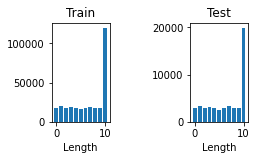

In [ ]:
from collections import Counter

flat_test = [item for sublist in y_synth_test for item in sublist]
flat_train = [item for sublist in y_synth_train for item in sublist]


train_num_length = Counter(flat_train)
test_num_length = Counter(flat_test)

plt.figure()

plt.subplot(251)
plt.bar(train_num_length.keys(), train_num_length.values(), align='center')
plt.title('Train')
plt.xlabel('Length')

plt.subplot(253)
plt.bar(test_num_length.keys(), test_num_length.values(), align='center')
plt.title('Test')
plt.xlabel('Length')

Text(0.5, 0, 'Length')

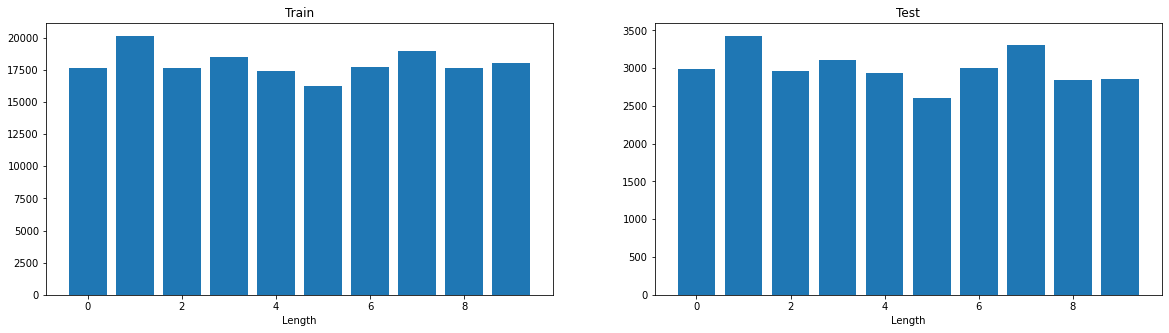

In [ ]:
flat_test_reduced = []
flat_train_reduced = []
for sublist in y_synth_test:
    for item in sublist:
      if item is not 10:
        flat_test_reduced.append(item)
        
for sublist in y_synth_train:
    for item in sublist:
      if item is not 10:
        flat_train_reduced.append(item)
        


train_num_length_reduced = Counter(flat_train_reduced)
test_num_length_reduced = Counter(flat_test_reduced)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))


ax1.bar(train_num_length_reduced.keys(), train_num_length_reduced.values(), align='center')
ax1.set_title('Train')
ax1.set_xlabel('Length')

ax2.bar(test_num_length_reduced.keys(), test_num_length_reduced.values(), align='center')
ax2.set_title('Test')
ax2.set_xlabel('Length')

## Deploy 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
MODEL_DIR = tempfile.gettempdir()

In [ ]:
MODEL_DIR

'/tmp'

In [ ]:
version = 1 

In [ ]:
# Let's join the temp model directory with our chosen version number 
# The expected result will be = '\tmp\version number'
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

export_path = /tmp/1



In [ ]:
# Let's save the model using simple_save
# If the directory already exists, we will remove it using '!rm' 
# rm removes each file specified on the command line. 

if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

model.save(
    export_path,)


INFO:tensorflow:Assets written to: /tmp/1/assets


In [ ]:
!ls -l {export_path}

total 296
drwxr-xr-x 2 root root   4096 Apr 25 19:22 assets
-rw-r--r-- 1 root root  30105 Apr 25 19:22 keras_metadata.pb
-rw-r--r-- 1 root root 259561 Apr 25 19:22 saved_model.pb
drwxr-xr-x 2 root root   4096 Apr 25 19:22 variables


In [ ]:
# Now we can view our saved model
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 64, 64, 1)
        name: serving_default_input_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_10'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 11)
        name: StatefulPartitionedCall:0
    outputs['dense_11'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 11)
        name: StatefulPartitionedCall:1
    outputs['dense_7'] tensor_info:
        dtype:

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  60061      0 --:--:-- --:--:-- --:--:-- 58860
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/u

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 56 not upgraded.
Need to get 340 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.8.0 [340 MB]
Fetched 340 MB in 7s (50.6 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155501 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.8.0_all.deb ...
Unpacking tensorflow-model-server (2.8.0) ...
Setting up tensorflow-model-server (2.8.0) ...


In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [ ]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


In [ ]:
def show(idx, title):
  plt.figure()
  plt.imshow(X_test[idx].reshape(64,64))
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})


In [ ]:
rando = random.randint(0,len(X_test)-1)


ValueError: ignored

<Figure size 432x288 with 0 Axes>